# Import and download libraries

## Clone git to which text embeddings will be added

In [ ]:
! git clone https://github.com/MateVaradi/OscarPrediction.git # Git from which main data will be retreived

Cloning into 'OscarPrediction'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 211 (delta 6), reused 7 (delta 3), pack-reused 194
Receiving objects: 100% (211/211), 1.90 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (113/113), done.


## Download selenium on colab

### ALWAYS CHECK LOGS CAUSE SOMETIMES DIFFERENT LIBRARIES  ARE NEEDED FOR SUCCESSFUL INSTALLATION

In [ ]:
%%shell
sudo apt -y update
sudo apt install libvulkan1
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium
pip install selenium chromedriver_autoinstaller

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [737 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,353 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,045 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,961 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,879 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [3

## Download some extra packages for parsing and dwonloading datasets

In [ ]:
! pip install rotten_tomatoes_scraper bs4 lxml IMDbPY kaggle random_user_agent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 36.5 MB/s eta 0:00:00


## Upload your kaggle.json (https://www.kaggle.com/discussions/general/156610) file for downloading datasets

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d miazhx/metacritic-movie-reviews
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
! kaggle datasets download -d garcibo/metacritic-movie-15k-review-582k-dataset
! kaggle datasets download -d mechamod/metacritic-500k-reviews
! kaggle datasets download -d talha002/rottentomatoes-400k-review
! kaggle datasets download -d andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews
! kaggle datasets download -d unanimad/the-oscar-award

! unzip /content/metacritic-movie-15k-review-582k-dataset.zip -d /content/kaggle_1
! unzip /content/metacritic-movie-reviews.zip -d /content/kaggle_2
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip -d /content/kaggle_3
! unzip /content/metacritic-500k-reviews.zip -d /content/kaggle_4
! unzip /content/rottentomatoes-400k-review.zip -d /content/kaggle_5
! unzip /content/clapper-massive-rotten-tomatoes-movies-and-reviews.zip -d /content/kaggle_6
! unzip /content/the-oscar-award.zip -d /content/kaggle_7

 27% 5.00M/18.4M [00:00<00:00, 26.2MB/s]
100% 18.4M/18.4M [00:00<00:00, 68.8MB/s]
 19% 5.00M/25.7M [00:00<00:00, 32.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 113MB/s] 
 90% 89.0M/99.1M [00:01<00:00, 66.1MB/s]
100% 99.1M/99.1M [00:01<00:00, 80.3MB/s]
 90% 98.0M/108M [00:01<00:00, 76.5MB/s]
100% 108M/108M [00:01<00:00, 67.5MB/s] 
 68% 21.0M/30.7M [00:00<00:00, 37.7MB/s]
100% 30.7M/30.7M [00:00<00:00, 50.8MB/s]
 95% 144M/152M [00:01<00:00, 129MB/s]
100% 152M/152M [00:01<00:00, 114MB/s]
  0% 0.00/204k [00:00<?, ?B/s]
100% 204k/204k [00:00<00:00, 134MB/s]
Archive:  /content/metacritic-movie-15k-review-582k-dataset.zip
  inflating: /content/kaggle_1/descriptionsForTraining.txt  
  inflating: /content/kaggle_1/movieDatasetClean.csv  
  inflating: /content/kaggle_1/reviewDatasetClean.csv  
Archive:  /content/metacritic-movie-reviews.zip
  inflating: /content/kaggle_2/metacritic_movies.csv  
  inflating: /content/kaggle_2/metacritic_reviews.csv  
Archive:  /content/imdb-dataset-of-50k-movie-reviews

In [ ]:
# To connect to google drive
from google.colab import drive
# For data processing
import pandas as pd
import numpy as np
# For parsing data
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from rotten_tomatoes_scraper.rt_scraper import MovieScraper
from imdb import Cinemagoer
import bs4, lxml
from selenium.webdriver.common.by import By
from selenium import webdriver
import chromedriver_autoinstaller
from bs4 import BeautifulSoup
import requests
from random_user_agent.user_agent import  UserAgent
from random_user_agent.params import SoftwareName, OperatingSystem
# For multithreaing processes
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool
# Insert path to chrome-driver in system
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chromedriver_autoinstaller.install()
# For loading screenshot
from PIL import Image
# For downloading files
import pickle
# To check processes in python
from tqdm import tqdm
# To check time and work with dirs
import time, os
from multiprocessing import Pool

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare some dataframes that will be used later

## Prepare driver

In [ ]:
! pip show selenium

Name: selenium
Version: 4.18.1
Summary: 
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, trio, trio-websocket, typing_extensions, urllib3
Required-by: 


In [ ]:
def get_driver():

    """
    This function just prepares drive with some settings
    """

    # Get random user_agent
    user_agents = [
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.139 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.85 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.85 Safari/537.36 (compatible; Googlebot/2.1; http://www.google.com/bot.html)',
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko; compatible; Googlebot/2.1; +http://www.google.com/bot.html) Chrome/111.0.5563.64 Safari/537.36',
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.6261.94 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.142 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'
                  ]
    # Choise randomly user agent
    user_agent = random.choice(user_agents)
    print(user_agent)

    # setup chrome options
    chrome_options = webdriver.ChromeOptions()
    #run in headless mode
    chrome_options.add_argument('--headless')
    # disable sandbox mode
    chrome_options.add_argument('--no-sandbox')
    # disable extensions
    chrome_options.add_argument("--disable-extensions")
    # Define user
    chrome_options.add_argument(f"user-agent={user_agent}")
    # disable shared memory usage
    chrome_options.add_argument('--disable-dev-shm-usage')
    # disable the AutomationControlled feature of Blink rendering engine
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2,})
    # Disable gpu
    chrome_options.add_argument("--disable-gpu")

    # set up the webdriver
    driver = webdriver.Chrome(options=chrome_options)

    return driver

In [ ]:
driver = get_driver()

## Get screenshot

In [ ]:
driver.get('https://www.rottentomatoes.com/m/happy_gilmore')
path = '/content/screenshot.jpg'
driver.save_screenshot(path)

/usr/local/lib/python3.10/dist-packages/selenium/webdriver/remote/webdriver.py:822: UserWarning: name used for saved screenshot does not match file type. It should end with a `.png` extension
  return self.get_screenshot_as_file(filename)


True

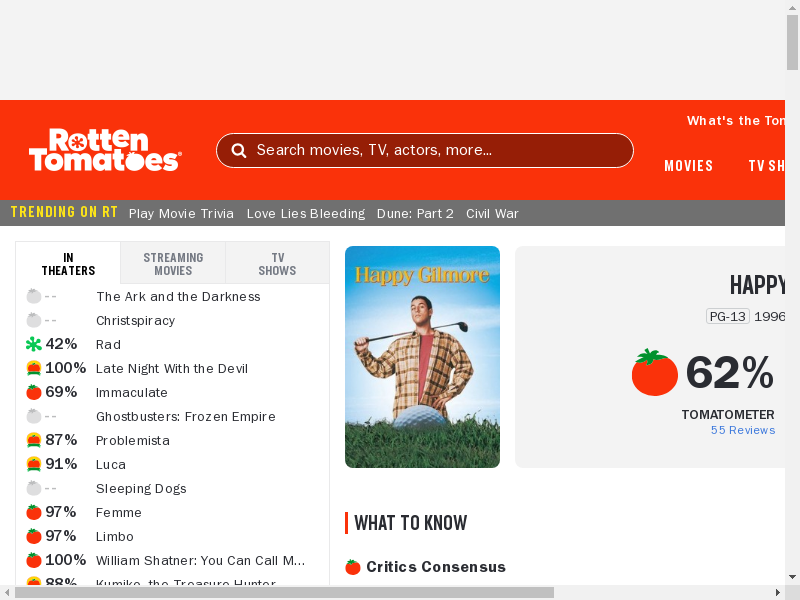

In [ ]:
screenshot = Image.open(path)
screenshot

## Prepare dataframes

In [ ]:
# main datasets that are used here for movie analysis
metacritic_250k_df = pd.read_csv('/content/kaggle_2/metacritic_reviews.csv', index_col=0)
huge_rotten_tomattoes_df = pd.read_csv('/content/kaggle_6/rotten_tomatoes_movie_reviews.csv')
huge_tomattoes_movies_df = pd.read_csv('/content/kaggle_6/rotten_tomatoes_movies.csv')
oscar_award_df = pd.read_csv('/content/kaggle_7/the_oscar_award.csv')

# You can uncomment the following datasets and check it

# cleaned_df = pd.read_csv('/content/drive/MyDrive/project/final_simple_project_data.csv', index_col=0)
# movies_df = pd.read_csv('/content/kaggle_2/metacritic_movies.csv', index_col=0)
# reviews_50k_df = pd.read_csv('/content/kaggle_3/IMDB Dataset.csv', index_col=0)
# metacritic_15k_df = pd.read_csv('/content/kaggle_1/reviewDatasetClean.csv', index_col=0, lineterminator='\n')
# movies_15k_df = pd.read_csv('/content/kaggle_1/movieDatasetClean.csv', index_col=0)
# metacritic_500k_df = pd.read_csv('/content/kaggle_4/Metacritic_reviews.csv', index_col=0, sep='µ')
# rotten_tommatoes_400k_df = pd.read_csv('/content/kaggle_5/rottentomatoes-400k.csv', index_col=0)

## clone repo for retreiving rotten tomattoes reviews

In [ ]:
! git clone https://github.com/preritdas/rottentomatoes-python.git

Cloning into 'rottentomatoes-python'...
remote: Enumerating objects: 889, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 889 (delta 209), reused 337 (delta 185), pack-reused 490
Receiving objects: 100% (889/889), 363.95 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (449/449), done.


In [ ]:
%cd /content/rottentomatoes-python

/content/rottentomatoes-python


In [ ]:
import rottentomatoes as rt

In [ ]:
movie = rt.Movie("happy gilmore")

In [ ]:
movie.url

'https://www.rottentomatoes.com/m/happy_gilmore'

## Check oscar winners df

In [ ]:
oscar_award_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10889 entries, 0 to 10888
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10889 non-null  int64 
 1   year_ceremony  10889 non-null  int64 
 2   ceremony       10889 non-null  int64 
 3   category       10889 non-null  object
 4   name           10884 non-null  object
 5   film           10570 non-null  object
 6   winner         10889 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 521.2+ KB


In [ ]:
oscar_award_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


## Check oscar-winner categories

In [ ]:
unique_values_oscar_category = oscar_award_df['category'].unique()

In [ ]:
unique_values_oscar_category

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)',
       'SPECIAL AWARD', 'DIRECTING', 'WRITING', 'OUTSTANDING PRODUCTION',
       'SOUND RECORDING', 'SHORT SUBJECT (Cartoon)',
       'SHORT SUBJECT (Comedy)', 'SHORT SUBJECT (Novelty)',
       'ASSISTANT DIRECTOR', 'FILM EDITING', 'MUSIC (Scoring)',
       'MUSIC (Song)', 'DANCE DIRECTION', 'WRITING (Screenplay)',
       'ACTOR IN A SUPPORTING ROLE', 'ACTRESS IN A SUPPORTING ROLE',
       'SHORT SUBJECT (Color)', 'SHORT SUBJECT (One-reel)',
       'SHORT SUBJECT (Two-reel)', 'IRVING G. THALBERG MEMORIAL AWARD',
       'MUSIC (Original Score)', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'SPECIAL EFFECTS',
       'ART DIRECTION (Black-and-White)', 'ART DIRECT

## Get oscar-winner movies

In [ ]:
oscar_winners_df = oscar_award_df[oscar_award_df['winner'].isin([True])]

In [ ]:
oscar_winners_df

,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10880,2023,2024,96,WRITING (Original Screenplay),Screenplay - Justine Triet and Arthur Harari,Anatomy of a Fall,True
10885,2023,2024,96,JEAN HERSHOLT HUMANITARIAN AWARD,NaN,NaN,True
10886,2023,2024,96,HONORARY AWARD,"To Angela Bassett, who has inspired audiences ...",NaN,True
10887,2023,2024,96,HONORARY AWARD,"To Mel Brooks, for his comedic brilliance, pro...",NaN,True


In [ ]:
# Drop rows with Nan
oscar_winners_df.dropna(inplace=True)

<ipython-input-25-88f09f0aed1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oscar_winners_df.dropna(inplace=True)


In [ ]:
oscar_winners_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 1 to 10880
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      2172 non-null   int64 
 1   year_ceremony  2172 non-null   int64 
 2   ceremony       2172 non-null   int64 
 3   category       2172 non-null   object
 4   name           2172 non-null   object
 5   film           2172 non-null   object
 6   winner         2172 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 120.9+ KB


# Get rotten tomattoes topcritic df and analyze data

In [ ]:
huge_rotten_tomattoes_topcritic_df = huge_rotten_tomattoes_df[huge_rotten_tomattoes_df['isTopCritic'].isin([True])]

In [ ]:
rotten_tommatoes_topcritic_df = pd.merge(huge_rotten_tomattoes_topcritic_df, huge_tomattoes_movies_df[['id', 'title']], on='id')
rotten_tommatoes_topcritic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444349 entries, 0 to 444348
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              444349 non-null  object
 1   reviewId        444349 non-null  int64 
 2   creationDate    444349 non-null  object
 3   criticName      444349 non-null  object
 4   isTopCritic     444349 non-null  bool  
 5   originalScore   278418 non-null  object
 6   reviewState     444349 non-null  object
 7   publicatioName  444349 non-null  object
 8   reviewText      433693 non-null  object
 9   scoreSentiment  444349 non-null  object
 10  reviewUrl       369772 non-null  object
 11  title           442649 non-null  object
dtypes: bool(1), int64(1), object(10)
memory usage: 41.1+ MB


## Compare the number of rotten tomattoes and metacritic reviews for oscar winner movies

### The next cell calculates oscar-winner movies at any nominations and checks how many films from it have metacritic and rotten tomattoes reviews

In [ ]:
main_category_winners_unique_names = list(set(oscar_winners_df['film'].tolist()))
print('Len of oscar winners list - ', len(main_category_winners_unique_names))
main_category_winners_metacritic_df = metacritic_250k_df[metacritic_250k_df['movie_title'].isin(main_category_winners_unique_names)]
main_category_winners_metacritic_unique_movie = list(set(main_category_winners_metacritic_df['movie_title'].tolist()))
print("Len of oscar winners list with METACRITIC reviews - ", len(main_category_winners_metacritic_unique_movie))

main_category_winners_tomattoes_df = rotten_tommatoes_topcritic_df[rotten_tommatoes_topcritic_df['title'].isin(main_category_winners_unique_names)]
main_category_winners_tomattoes_unique_movie = list(set(main_category_winners_tomattoes_df['title'].tolist()))
print("Len of oscar winners list with ROTTEN TOMATTOES reviews - ", len(main_category_winners_tomattoes_unique_movie))

Len of oscar winners list -  1328
Len of oscar winners list with METACRITIC reviews -  537
Len of oscar winners list with ROTTEN TOMATTOES reviews -  893


## **As you can see there are many movies without reviews. Besides, main dataset with nominations lack data**

### *Cause of these reasons the different dataset (it contains much more data) is used in similar way - rotten tomattoes and metacritic reviews are added to it from previous datasets. Films that  still lack reviews will be supplied text data using parsing*

# Prepare MAIN dataframe with different sets of movies that include additional data. Besides to that data, reviews will be added to this df

In [ ]:
variable_selection = pd.read_excel('/content/OscarPrediction/predictor_selection.xlsx')
variable_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Variable           77 non-null     object 
 1   Picture            50 non-null     float64
 2   Director           42 non-null     float64
 3   Lead Acting        59 non-null     float64
 4   Supporting Acting  57 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


## Check how many movies lack metacritic and rotten tomattoes reviews in main dataframe as we did before

In [ ]:
df_picture = pd.read_csv('/content/OscarPrediction/data/oscardata_bestpicture.csv')

main_category_winners_unique_names = list(set(df_picture['Film'].tolist()))
print('Len of oscar winners list - ', len(main_category_winners_unique_names))
main_category_winners_metacritic_df = metacritic_250k_df[metacritic_250k_df['movie_title'].isin(main_category_winners_unique_names)]
main_category_winners_metacritic_unique_movie = list(set(main_category_winners_metacritic_df['movie_title'].tolist()))
print("Len oscar winners list with METACRITIC reviews - ", len(main_category_winners_metacritic_unique_movie))

main_category_winners_tomattoes_df = rotten_tommatoes_topcritic_df[rotten_tommatoes_topcritic_df['title'].isin(main_category_winners_unique_names)]
main_category_winners_tomattoes_unique_movie = list(set(main_category_winners_tomattoes_df['title'].tolist()))
print("Len oscar winners list with ROTTEN TOMATTOES reviews - ", len(main_category_winners_tomattoes_unique_movie))

Len of oscar winners list -  359
Len oscar winners list with METACRITIC reviews -  285
Len oscar winners list with ROTTEN TOMATTOES reviews -  336


## Form unique sets for later use

In [ ]:
unique_set = set(main_category_winners_unique_names)
metacritic_set = set(main_category_winners_metacritic_unique_movie)
tomattoes_set = set(main_category_winners_tomattoes_unique_movie)
movies_without_metacritic_reviews = list(unique_set.difference(metacritic_set))
movies_without_rt_reviews = list(unique_set.difference(tomattoes_set))
print(movies_without_metacritic_reviews)
print(movies_without_rt_reviews)

['Kiss of the Spider Woman', 'Ship of Fools', 'The Godfather Part II', 'Taxi Driver', 'The Russians Are Coming, the Russians Are Coming', "Coal Miner's Daughter", 'Nomadland', 'The Trial of the Chicago 7', 'BlacKkKlansman', 'Cries and Whispers', 'The Father', 'Sons and Lovers', 'Precious', 'Anne of the Thousand Days', 'Romeo and Juliet', 'Doctor Dolittle', 'A Touch of Class', 'Birdman or (The Unexpected Virtue of Ignorance)', 'The Dresser', 'The Exorcist', 'Amadeus', 'Drive My Car', 'Licorice Pizza', "A Soldier's Story", 'Annie Hall', 'Good Night, and Good Luck', 'The French Connection', 'Nicholas and Alexandra', 'Sound of Metal', 'E.T. the Extra-Terrestrial', 'The Emigrants', 'Promising Young Woman', 'The Guns of Navarone', 'Captain Phillips', 'How the West Was Won', 'Nightmare Alley', 'The Lion in Winter', 'Crouching Tiger, Hidden Dragon (Wo hu cang long)', 'Funny Girl', 'Minari', 'Judas and the Black Messiah', 'Z', '1917', 'M*A*S*H', 'Star Wars', 'Love Story', 'A Passage to India', 

# ***PARSING!!!***

#You can skip the following cells and just download missing reviews or check how the data was got

### Brief information about multithreading and multiprocesses

https://www.geeksforgeeks.org/multithreading-or-multiprocessing-with-python-and-selenium/

***Multithreading and multiprocessing*** are two popular approaches for improving the performance of a program by allowing it to run tasks in parallel. These approaches can be particularly useful when working with Python and Selenium, as they allow you to perform multiple actions simultaneously, such as automating the testing of a web application.

It is important to understand the **fundamental differences** between these approaches.

***Multithreading:*** Multithreading is the ability of a central processing unit (CPU) (or a single core in a multi-core processor) to provide multiple threads of execution concurrently, supported by the operating system. This allows a program to run multiple threads concurrently, with each thread running a separate task. In Python, the threading module provides support for multithreading.

***Multiprocessing:*** Multiprocessing is the ability to execute multiple concurrent processes within a system. Unlike multithreading, which allows multiple threads to run on a single CPU, multiprocessing allows a program to run multiple processes concurrently, each on a separate CPU or core. In Python, the multiprocessing module provides support for multiprocessing.
It is important to note that multithreading and multiprocessing are not mutually exclusive, and it is possible to use both approaches in a single program. However, there are some key differences to consider when deciding which approach is best for a given task.

***Performance:*** In general, multiprocessing is more efficient than multithreading, as it allows a program to take full advantage of multiple CPU cores. However, multithreading can still be useful in certain situations, such as when a program is **I/O bound** (i.e., waiting for input/output operations to complete) rather than CPU bound.

**Shared state:** One of the major differences between multithreading and multiprocessing is the way that they handle shared state. In multithreading, threads share the same memory space, which means that they can access and modify shared variables. In contrast, processes in multiprocessing do not share a memory and must communicate with each other through interprocess communication (IPC) mechanisms such as pipes or shared memory.

**Concurrency:** Both multithreading and multiprocessing allow a program to execute tasks concurrently. However, there are some key differences to consider when it comes to concurrency. In multithreading, the Python interpreter is responsible for managing the threads, meaning that the program can only run as many threads as CPU cores. In contrast, multiprocessing allows a program to create as many processes as there are CPU cores, which can potentially lead to better performance.


### ***Cause of this reasons multithreading will be used to get urls for websites and multiprocessing for scraping reviews from rotten tomattoes and metacritic. Process of cpu will be always 2 for colab because it has 2 cpu and further increasing will not have much of improving. For multithreading you can define your own number/ In this notebook usually used 4-8***

In [ ]:
from psutil import cpu_count
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())

Number of CPU:  2


In [ ]:
def create_rt_urls(movie_names):

    """
    This function adds url to films that are without rt reviews using
    external dict urls_wt_rt_dict

    Parameters:
    movie_names (list): list that contains movie names

    Returns:
    dict: dict with urls
    """

    for movie_name in tqdm(movie_names, total=len(movie_names)):
        movie = rt.Movie(movie_name)
        urls_wt_rt_dict[movie_name] = movie.url

    return urls_wt_rt_dict

def use_threadpool(cpu, function, data):

    """
    This is the main function that is used for MULTITHREADING in the entire
    notebook

    Parameters:
    cpu (int): Threads number
    function (object): function which is used for multithreading
    **data_dict (dict): Dict that always has 2 values: data which are used in
    function and drivers - list with drivers (it equals None if drivers are not
    used in function)
    """

    with ThreadPoolExecutor(cpu) as p:

                  p.map(
                        function,
                        data
                        )

def use_mp_pool(cpu, function, data):

    """
    This is the main function that is used for MULTIPROCESSING in the entire
    notebook

    Parameters:
    cpu (int): CPU number
    function (object): function which is used for multiprocessing
    data (list): data splitted for the all processes

    Return:
    bucket (list): list with content from the multpipocessing
    t (float): time for this function (seconds)
    """

    start_time = time.time()

    # with ThreadPoolExecutor(cpu) as p:
    with Pool(cpu) as p:

        bucket = p.map(
                      function,
                      data
                      )

    end_time = time.time()
    t = end_time-start_time

    return bucket, t

def parse_multiple_times(cpu, function, attempt_number, data, wait_time=5):

    """
    This is the function that is used for trying the MULTIPROCESSING
    attempt_number tumes

    Parameters:
    cpu (int): CPU number
    function (object): function which is used for multiprocessing
    attemot_number (int): number to try multiprocessing function
    data (list): data splitted for the all processes

    Return:
    bucket (list): list with content from the multpipocessing
    t (float): time for this function (seconds)
    """

    start_time = time.time()
    old_bucket = []

    for a in range(attempt_number):

        print("-"*100)
        print(f"ATTEMPT NO {a+1}")

        bucket, _ = use_mp_pool(cpu, function, [(d, wait_time) for d in data])

        data_wt_reviews = [k for mc_dict in bucket for k,v in mc_dict.items() if not v]

        if not data_wt_reviews:

            end_time = time.time()
            t = end_time-start_time
            return bucket, t

        else:

            print(f"\nNUMBER URLS THAT WEBDRIVER DIDN'T CONNECT TO = {len(data_wt_reviews)}")
            print(f"\nTHEIR NAMES = {data_wt_reviews}")
            data = [d for chunk in data for d in chunk if d in data_wt_reviews]
            data = np.array_split(data, cpu)
            old_bucket.extend(bucket)
            if a + 1 == attempt_number:
                break
            print("SLEEP FOR 15 SECONDS BEFORE THE NEXT TRY")
            time.sleep(15)

            continue

    end_time = time.time()
    t = end_time-start_time

    return old_bucket, t

## Get rt urls before parsing reviews

In [ ]:
# Define threads number and data chunks
cpu=4
sp_array_movie_names = np.array_split(movies_without_rt_reviews,cpu)

In [ ]:
# Get urls for rotten tomattoes
urls_wt_rt_dict = {name:None for name in movies_without_rt_reviews}

use_threadpool(cpu, create_rt_urls,
               data=sp_array_movie_names)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:01<00:08,  1.78s/it]


 20%|██        | 1/5 [00:02<00:08,  2.01s/it]

 33%|███▎      | 2/6 [00:03<00:06,  1.63s/it]


 33%|███▎      | 2/6 [00:03<00:07,  1.84s/it]

 50%|█████     | 3/6 [00:05<00:05,  2.00s/it]


 60%|██████    | 3/5 [00:06<00:04,  2.07s/it]

 67%|██████▋   | 4/6 [00:07<00:03,  1.77s/it]

 83%|████████▎ | 5/6 [00:07<00:01,  1.52s/it]


 83%|████████▎ | 5/6 [00:08<00:01,  1.68s/it]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

 83%|████████▎ | 5/6 [00:09<00:01,  1.87s/it]

100%|██████████| 6/6 [00:09<00:00,  1.59s/it]

100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


### Get dict with rotten tomattoes missing reviews

In [ ]:
def get_rt_reviews(params_tuple):

    """
    This is the function that works in a similar way to calculate_current_list -
    just fill in reviews that parse using driver

    Parameters:
    movie_names (list): list with movie names. Using them as a key to tomattoes
    urls
    driver: Selenium driver to get data
    """
    movie_names, time_to_sleep = params_tuple
    current_i = 1
    rt_dict = {name:[] for name in movie_names}
    driver= get_driver()
    i = -1

    for movie_name in tqdm(movie_names, total=len(movie_names), unit='movie_name'):
        print(f'\n{movie_name}')
        i += 1
        # Get url
        url = urls_wt_rt_dict[movie_name]
        # Get connection to the driver
        try:
            # Get url
            url += '/reviews?type=top_critics'
            driver.get(url)
            time.sleep(time_to_sleep)
            current_i=1

        except Exception as e:
            print(f"\nTIMEOUT EXCEPTION OCCURED IN {current_i} TIME IN A ROW")
            current_i += 1

            if current_i > 5:
                print(f"DRIVER STOPPED CONNECTING TO THE URLS, UPDATE THE ALL ITERATION")
                break

            driver = get_driver()

            continue

        # Upload all reviews via LOAD MORE button on the rt site
        movie_reviews = driver.find_elements(By.CSS_SELECTOR, 'p.review-text')
        old_review_number = 10000000
        new_review_number = len(movie_reviews)
        # Check if amount of reviews are changed
        while new_review_number != old_review_number:
            old_review_number = new_review_number
            button = driver.find_elements(By.CSS_SELECTOR, 'div.load-more-container')
            button[0].click()
            time.sleep(2)
            movie_reviews = driver.find_elements(By.CSS_SELECTOR, 'p.review-text')
            new_review_number = len(movie_reviews)

        # Get reviews
        for movie_review in movie_reviews:
            if len(movie_review.text) == 0:
                continue
            # Add reviews to the dict
            rt_dict[movie_name].append(movie_review.text)

        if i%10 == 0:
            driver.quit()
            driver = get_driver()

    driver.quit()

    return rt_dict

In [ ]:
# Define parameters for multithreading
cpu=2
sp_array_movie_names = np.array_split(movies_without_rt_reviews,cpu)

### Using wait_time = 0 for rotten tomattoes reviews is ok even with vpn but you could define your time

In [ ]:
bucket, t = parse_multiple_times(cpu, get_rt_reviews, attempt_number=2,
                                 data=sp_array_movie_names, wait_time=0)

----------------------------------------------------------------------------------------------------
ATTEMPT NO 1


  0%|          | 0/12 [00:00<?, ?movie_name/s]


Ship of Fools


  0%|          | 0/11 [00:00<?, ?movie_name/s]


The Right Stuff


  8%|▊         | 1/12 [00:06<01:16,  6.91s/movie_name]


Moulin Rouge!


  9%|▉         | 1/11 [00:07<01:11,  7.17s/movie_name]


Lady Bird


 17%|█▋        | 2/12 [00:21<01:57, 11.71s/movie_name]


Letters from Iwo Jima


 18%|█▊        | 2/11 [00:25<02:04, 13.83s/movie_name]


Crouching Tiger, Hidden Dragon (Wo hu cang long)


 27%|██▋       | 3/11 [00:29<01:14,  9.25s/movie_name]


Extremely Loud and Incredibly Close


 25%|██▌       | 3/12 [00:32<01:41, 11.33s/movie_name]


The Godfather Part II


 33%|███▎      | 4/12 [00:39<01:14,  9.34s/movie_name]


The Russians Are Coming, the Russians Are Coming


 36%|███▋      | 4/11 [00:41<01:12, 10.30s/movie_name]


Star Wars


 42%|████▏     | 5/12 [00:44<00:55,  7.97s/movie_name]


Precious


 45%|████▌     | 5/11 [00:56<01:11, 11.86s/movie_name]


The Godfather Part III


 50%|█████     | 6/12 [00:57<00:56,  9.46s/movie_name]


In the Heat of the Night


 55%|█████▍    | 6/11 [01:00<00:46,  9.23s/movie_name]



Rachel, Rachel

 58%|█████▊    | 7/12 [01:03<00:42,  8.55s/movie_name]


Bound for Glory


 67%|██████▋   | 8/12 [01:08<00:28,  7.22s/movie_name]


Good Night, and Good Luck


 64%|██████▎   | 7/11 [01:09<00:37,  9.25s/movie_name]


Secrets and Lies


 73%|███████▎  | 8/11 [01:16<00:25,  8.56s/movie_name]


America America


 75%|███████▌  | 9/12 [01:21<00:27,  9.02s/movie_name]


Dances with Wolves


 82%|████████▏ | 9/11 [01:20<00:14,  7.15s/movie_name]


The Sand Pebbles


 91%|█████████ | 10/11 [01:25<00:06,  6.53s/movie_name]


Once Upon a Time in Hollywood


 83%|████████▎ | 10/12 [01:29<00:17,  8.88s/movie_name]


Il Postino: The Postman


 92%|█████████▏| 11/12 [01:34<00:07,  7.63s/movie_name]


Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb


100%|██████████| 11/11 [01:41<00:00,  9.21s/movie_name]


In [ ]:
# Get the dict with rt reviews
rt_dict = {k:v for d in bucket for k, v in d.items()}

In [ ]:
len(rt_dict)

23

## Get missing metacritic reviews using similar way.
## ***TURN ON VPN IF THERE ARE SOME CONSTRICTIONS WITH YOUR NET***

### Get review for interstellar for instance

In [ ]:
driver = get_driver()
url = 'https://www.metacritic.com/movie/interstellar/critic-reviews/'
driver.get(url)

In [ ]:
movie_reviews = driver.find_elements(By.CSS_SELECTOR, 'div.c-siteReview_quote')
movie_reviews[3].text

'Brainy, barmy and beautiful to behold, this is Stephen Hawking’s Star Trek: a mind-bending opera of space and time with a soul wrapped up in all the science.'

In [ ]:
driver.quit()

## Let's collect *metacritic* names
*Metacritic* names - these are just names that used in url to film in metacritic url. However, there are some difficult cases when multiple movies have the same name or there is tv show and movie with the same name. Cause of such problem metacritic names are retrieved from the link on metacritic web

In [ ]:
def get_movies_wt_mc(movie_names, driver=None):

    """
    This function uses film names and seacrh on metacritic search web. If movie
    with the name exists it appends it to list with reviews and vice versa

    Parameters:
    movie_names (list): list with movie titles without metacritic reviews
    """

    for movie_title in tqdm(movie_names, total=len(movie_names)): # iterate over movie titles

        # Retrieve the first word from the title
        first_title_word = movie_title.split()[0].lower()
        # Replace spaces with metacritic pattern (%20 in our case)
        modified_movie_title = movie_title.lower().replace(' ', '%20')
        # Get search url for all variants of movies, tv shows with common name
        search_url = f'https://www.metacritic.com/search/{modified_movie_title}/?page=1&category=2'
        # Make soup from the search url
        response = requests.get(search_url, headers = user_agent)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Get containers (tv shows, movies) with information
        containers = soup.find_all('div', class_='g-grid-container u-grid-columns')
        # Iterate over tv shows and movies
        for i, container in enumerate(containers[0:4]):
            metacritic_name = container.find('a').get('href')

            # If name is the same and container has movie pattern then append it
            if 'movie' in metacritic_name and first_title_word in metacritic_name:
                metacritic_names.append((metacritic_name, movie_title))
                break

            # If there is not movie with such names then movie does not have metacritic reviews
            if i == 3:
                empty_metacritic_reviews.append(movie_title)

In [ ]:
# Define parameters for multithreading and lists for function
cpu=8
sp_array_movie_names = np.array_split(movies_without_metacritic_reviews,cpu)

user_agent = {'User-agent': 'Mozilla/5.0'}
metacritic_names = []
empty_metacritic_reviews = []

In [ ]:
# Apply multithreading
use_threadpool(cpu, get_movies_wt_mc,
               data=sp_array_movie_names)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


  0%|          | 0/9 [00:00<?, ?it/s]




  0%|          | 0/9 [00:00<?, ?it/s]






  0%|          | 0/9 [00:00<?, ?it/s]



  0%|          | 0/9 [00:00<?, ?it/s]





  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:00<00:04,  1.87it/s]





 11%|█         | 1/9 [00:00<00:05,  1.48it/s]




 10%|█         | 1/10 [00:01<00:08,  1.10it/s]






 10%|█         | 1/10 [00:01<00:08,  1.03it/s]



 11%|█         | 1/9 [00:01<00:08,  1.02s/it]


 11%|█         | 1/9 [00:01<00:09,  1.13s/it]

 22%|██▏       | 2/9 [00:01<00:04,  1.51it/s]




 22%|██▏       | 2/9 [00:01<00:05,  1.21it/s]



 22%|██▏       | 2/9 [00:01<00:05,  1.27it/s]





 22%|██▏       | 2/9 [00:01<00:06,  1.04it/s]

 33%|███▎      | 3/9 [00:02<00:04,  1.40it/s]


 22%|██▏       | 2/9 [00:02<00:07,  1.01s/it]






 20%|██        | 2/10 [00:02<00:09,  1.24s/it]




 33%|███▎      | 3/9 [00:02<00:05,  1.12it/s]



 33%|███▎      

## Check movies without reviews


In [ ]:
movies_without_mc_reviews = [i for _, i in metacritic_names]
movies_without_mc_dict = {name:pair for name, pair in zip(movies_without_mc_reviews, metacritic_names)}
print("Number of movies with reviews - ", len(movies_without_mc_reviews))
print("Number of movies without reviews - ", len(empty_metacritic_reviews))
empty_metacritic_reviews

Number of movies with reviews -  65
Number of movies without reviews -  9


['Elmer Gantry',
 'E.T. the Extra-Terrestrial',
 'Ship of Fools',
 'Anne of the Thousand Days',
 'Rachel, Rachel',
 'M*A*S*H',
 'The Sand Pebbles',
 "Don't Look Up",
 'Zorba the Greek']

## Get urls for metacritic reviews

In [ ]:
def create_mc_urls(movie_names, driver=None):

    """
    This function works in the same way as create_rt_urls that was defined
    previously

    Parameters:
    movie_names (list): list that contains movie names

    Returns:
    dict: dict with urls
    """

    for movie_title in tqdm(movie_names, total=len(movie_names)):
        metacritic_name, _ = movies_without_mc_dict[movie_title]
        url = f'https://www.metacritic.com{metacritic_name}critic-reviews/'
        urls_wt_mc_dict[movie_title] = url

    return urls_wt_mc_dict

In [ ]:
# Define parameters for multithreading
cpu=4
sp_array_movie_names = np.array_split(movies_without_mc_reviews,cpu)

In [ ]:
urls_wt_mc_dict = {name:None for name in movies_without_mc_reviews}
use_threadpool(cpu, create_mc_urls,
               data=sp_array_movie_names)

100%|██████████| 16/16 [00:00<00:00, 66576.25it/s]

100%|██████████| 16/16 [00:00<00:00, 114716.01it/s]


In [ ]:
def get_mc_reviews(params_tuple):

    """
    This is the function that works in a similar way to get_mc_reviews -
    just fill in reviews that parse using driver

    Parameters:
    movie_names (list): list with movie names. Using them as a key to metacritic
    urls

    driver: Selenium driver to get data
    """

    movie_names, time_wait = params_tuple
    driver = get_driver()
    mc_dict = {name:[] for name in movie_names}
    current_i=1
    i = -1
    # Iterate over movie_names
    for movie_name in tqdm(movie_names, total=len(movie_names)):
        i += 1
        print(" Name of movie - ", movie_name)

        # Get metacritic url
        try:
            url = urls_wt_mc_dict[movie_name]
            driver.get(url)
            WebDriverWait(driver, time_wait).until(EC.presence_of_element_located((By.XPATH, '//div[@class="c-siteLogo c-siteFooter_logo"]')))
            current_i=1

        except Exception as e:
            print(f"TIMEOUT EXCEPTION OCCURED IN {current_i} TIME IN A ROW")
            current_i += 1

            if current_i > 5:
                print(f"DRIVER STOPPED CONNECTING TO THE URLS, UPDATE THE ALL ITERATION")
                break

            driver.quit()
            driver = get_driver()

            continue

        # Get reviews
        movie_reviews = driver.find_elements(By.CSS_SELECTOR, 'div.c-siteReview_quote')
        # Append review to a list
        for movie_review in movie_reviews:
            mc_dict[movie_name].append(movie_review.text)

        if i%10==0:
            print("UPDATE DRIVER")
            driver.quit(); driver=get_driver()

    driver.quit()

    return mc_dict

### Metacritic is a bit difficult site to retrieve site at least for the author of this notebook. Sometimes you can get connection to some url and get reviews and sometimes you cannot. Several techniques are already in use to avoid this like always changing driver with new good user from defined user agents. Besides ,notebook utilizes WebDriverWait

### Also the speed of parsing strongly depends on your net and your user agent. In this notebook user agents has verty good speed. So don't worry if you run it in google colab. However, there may be some problem if you use different net like Opera or Firefox

### ***CHECK THE OTHER USER-AGENTS*** - ***https://explore.whatismybrowser.com/useragents/explore/software_name/googlebot/1***

In [ ]:
import random

In [ ]:
# Define parameters for multithreading
cpu=2
sp_array_movie_names = np.array_split(movies_without_mc_reviews,cpu)

In [ ]:
bucket, t = parse_multiple_times(cpu, get_mc_reviews, attempt_number=2,
                                 data=sp_array_movie_names, wait_time=10)

----------------------------------------------------------------------------------------------------
ATTEMPT NO 1
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.139 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.142 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


  0%|          | 0/32 [00:00<?, ?it/s]

 Name of movie -  Good Night, and Good Luck


  0%|          | 0/33 [00:00<?, ?it/s]

 Name of movie -  Amadeus
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.6261.94 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


  3%|▎         | 1/33 [00:06<03:19,  6.25s/it]

 Name of movie -  King Richard
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.139 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


  3%|▎         | 1/32 [00:07<03:40,  7.13s/it]

 Name of movie -  Romeo and Juliet


  6%|▋         | 2/32 [00:09<02:10,  4.34s/it]

 Name of movie -  Sounder


  6%|▌         | 2/33 [00:09<02:24,  4.67s/it]

 Name of movie -  Funny Girl


  9%|▉         | 3/32 [00:10<01:23,  2.87s/it]

 Name of movie -  Captain Phillips


  9%|▉         | 3/33 [00:11<01:42,  3.43s/it]

 Name of movie -  The Father


 12%|█▎        | 4/32 [00:12<01:11,  2.55s/it]

 Name of movie -  A Thousand Clowns


 12%|█▏        | 4/33 [00:13<01:21,  2.82s/it]

 Name of movie -  Kiss of the Spider Woman


 16%|█▌        | 5/32 [00:14<00:59,  2.20s/it]

 Name of movie -  Airport


 19%|█▉        | 6/32 [00:15<00:52,  2.02s/it]

 Name of movie -  The French Connection


 15%|█▌        | 5/33 [00:15<01:11,  2.54s/it]

 Name of movie -  The Godfather Part III


 22%|██▏       | 7/32 [00:18<00:50,  2.03s/it]

 Name of movie -  Coal Miner's Daughter


 18%|█▊        | 6/33 [00:17<01:04,  2.39s/it]

 Name of movie -  Drive My Car


 25%|██▌       | 8/32 [00:19<00:44,  1.85s/it]

 Name of movie -  How the West Was Won


 21%|██        | 7/33 [00:21<01:10,  2.72s/it]

 Name of movie -  Minari


 28%|██▊       | 9/32 [00:21<00:47,  2.05s/it]

 Name of movie -  Doctor Dolittle


 31%|███▏      | 10/32 [00:24<00:46,  2.11s/it]

 Name of movie -  Hope and Glory


 24%|██▍       | 8/33 [00:24<01:13,  2.92s/it]

 Name of movie -  Belfast
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.6261.94 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


 34%|███▍      | 11/32 [00:28<00:55,  2.67s/it]

 Name of movie -  Nicholas and Alexandra


 27%|██▋       | 9/33 [00:29<01:23,  3.48s/it]

 Name of movie -  America America


 38%|███▊      | 12/32 [00:32<01:01,  3.06s/it]

 Name of movie -  Nomadland


 30%|███       | 10/33 [00:33<01:22,  3.58s/it]

 Name of movie -  Licorice Pizza


 41%|████      | 13/32 [00:36<01:03,  3.33s/it]

  Name of movie - Star Wars
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko; compatible; Googlebot/2.1; +http://www.google.com/bot.html) Chrome/111.0.5563.64 Safari/537.36


 33%|███▎      | 11/33 [00:36<01:15,  3.41s/it]

 Name of movie -  The Emigrants


 44%|████▍     | 14/32 [00:37<00:52,  2.90s/it]

 Name of movie -  Nightmare Alley


 36%|███▋      | 12/33 [00:38<01:08,  3.25s/it]

 Name of movie -  An Unmarried Woman


 47%|████▋     | 15/32 [00:40<00:46,  2.76s/it]

 Name of movie -  A Touch of Class


 39%|███▉      | 13/33 [00:40<00:55,  2.78s/it]

 Name of movie -  Sons and Lovers


 50%|█████     | 16/32 [00:42<00:39,  2.49s/it]

 Name of movie -  Once Upon a Time in Hollywood


 42%|████▏     | 14/33 [00:42<00:45,  2.41s/it]

 Name of movie -  Judas and the Black Messiah


 53%|█████▎    | 17/32 [00:44<00:37,  2.52s/it]

 Name of movie -  Secrets and Lies


 45%|████▌     | 15/33 [00:44<00:44,  2.46s/it]

 Name of movie -  Lawrence of Arabia


 48%|████▊     | 16/33 [00:46<00:40,  2.38s/it]

 Name of movie -  Tender Mercies


 56%|█████▋    | 18/32 [00:47<00:36,  2.59s/it]

 Name of movie -  CODA


 52%|█████▏    | 17/33 [00:49<00:40,  2.50s/it]

 Name of movie -  Becket


 59%|█████▉    | 19/32 [00:50<00:36,  2.78s/it]

 Name of movie -  Sound of Metal


 55%|█████▍    | 18/33 [00:51<00:36,  2.42s/it]

 Name of movie -  The Godfather Part II


 62%|██████▎   | 20/32 [00:54<00:36,  3.00s/it]

 Name of movie -  The Trial of the Chicago 7


 58%|█████▊    | 19/33 [00:55<00:37,  2.66s/it]

 Name of movie -  A Soldier's Story
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko; compatible; Googlebot/2.1; +http://www.google.com/bot.html) Chrome/111.0.5563.64 Safari/537.36


 61%|██████    | 20/33 [00:58<00:36,  2.82s/it]

 Name of movie -  Precious


 66%|██████▌   | 21/32 [00:59<00:38,  3.52s/it]

 Name of movie -  Love Story
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.139 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


 64%|██████▎   | 21/33 [01:00<00:32,  2.70s/it]

 Name of movie -  The Post


 69%|██████▉   | 22/32 [01:01<00:32,  3.25s/it]

 Name of movie -  BlacKkKlansman


 72%|███████▏  | 23/32 [01:05<00:30,  3.42s/it]

 Name of movie -  The Lion in Winter


 67%|██████▋   | 22/33 [01:05<00:37,  3.38s/it]

 Name of movie -  Z


 75%|███████▌  | 24/32 [01:08<00:25,  3.18s/it]

 Name of movie -  Birdman or (The Unexpected Virtue of Ignorance)


 70%|██████▉   | 23/33 [01:08<00:30,  3.07s/it]

 Name of movie -  Promising Young Woman


 78%|███████▊  | 25/32 [01:11<00:22,  3.20s/it]

 Name of movie -  The Music Man


 73%|███████▎  | 24/33 [01:11<00:27,  3.01s/it]

 Name of movie - 
 The Power of the Dog

 81%|████████▏ | 26/32 [01:13<00:17,  2.87s/it]

 Name of movie -  Guess Who's Coming to Dinner


 76%|███████▌  | 25/33 [01:14<00:25,  3.13s/it]

 Name of movie -  Mank


 84%|████████▍ | 27/32 [01:14<00:12,  2.46s/it]

 Name of movie -  A Passage to India


 88%|████████▊ | 28/32 [01:17<00:09,  2.38s/it]

 Name of movie -  Cries and Whispers


 79%|███████▉  | 26/33 [01:17<00:21,  3.12s/it]

 Name of movie -  Taxi Driver


 91%|█████████ | 29/32 [01:19<00:07,  2.46s/it]

 Name of movie -  The Dresser


 82%|████████▏ | 27/33 [01:20<00:18,  3.13s/it]

 Name of movie -  Annie Hall


 94%|█████████▍| 30/32 [01:22<00:04,  2.41s/it]

 Name of movie -  Crouching Tiger, Hidden Dragon (Wo hu cang long)


 85%|████████▍ | 28/33 [01:23<00:14,  2.93s/it]

 Name of movie -  Hugo
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.139 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


 97%|█████████▋| 31/32 [01:25<00:02,  2.71s/it]

 Name of movie -  The Exorcist


 88%|████████▊ | 29/33 [01:26<00:12,  3.07s/it]

 Name of movie -  The Guns of Navarone


 91%|█████████ | 30/33 [01:27<00:07,  2.56s/it]

 Name of movie -  1917
UPDATE DRIVER
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.5615.142 Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)


 94%|█████████▍| 31/33 [01:30<00:04,  2.46s/it]

 Name of movie -  Lilies of the Field


 97%|█████████▋| 32/33 [01:31<00:02,  2.27s/it]

 Name of movie -  The Russians Are Coming, the Russians Are Coming


100%|██████████| 33/33 [01:33<00:00,  2.82s/it]


In [ ]:
with open('/content/drive/MyDrive/project/full_rt_20_mc_reviews_dicts/full_mc_dict.pkl', 'rb') as file:
    full_mc_dict = pickle.load(file)
    full_mc_dict = {key:full_mc_dict[key] for key in movies_without_mc_reviews}

In [ ]:
data_with_reviews = [v for mc_dict in bucket for k,v in mc_dict.items() if v]
print(len(data_with_reviews))
print("TIME=", t)
print("REVIEWS NUMBER", len([review for reviews in data_with_reviews for review in reviews]))

data_with_correct_reviews = [v for k,v in full_mc_dict.items() if v]
print(len(data_with_correct_reviews))
print("CORRECT REVIEWS NUMBER", len([review for reviews in data_with_correct_reviews for review in reviews]))

65
TIME= 94.56079316139221
REVIEWS NUMBER 1853
65
CORRECT REVIEWS NUMBER 1853


# Save dicts with reviews

In [ ]:
mc_dict = {k:v for d in bucket for k,v in d.items()}

In [ ]:
with open('/content/drive/MyDrive/project/rt_mc_text_reviews/rt_dict.pkl', 'wb') as file:
    pickle.dump(rt_dict, file)

with open('/content/drive/MyDrive/project/rt_mc_text_reviews/mc_dict.pkl', 'wb') as file:
    pickle.dump(mc_dict, file)

# Upload reviews

In [ ]:
with open('/content/drive/MyDrive/project/rt_mc_text_reviews/rt_dict.pkl', 'rb') as file:
    rt_dict = pickle.load(file)

with open('/content/drive/MyDrive/project/rt_mc_text_reviews/mc_dict.pkl', 'rb') as file:
    mc_dict = pickle.load(file)

In [ ]:
main_category_winners_unique_names = list(set(df_picture['Film'].tolist()))
print('Len of oscar winners list - ', len(main_category_winners_unique_names))
main_category_winners_metacritic_df = metacritic_250k_df[metacritic_250k_df['movie_title'].isin(main_category_winners_unique_names)]
main_category_winners_metacritic_unique_movie = list(set(main_category_winners_metacritic_df['movie_title'].tolist()))
print("Len oscar winners list with METACRITIC reviews - ", len(main_category_winners_metacritic_unique_movie))

main_category_winners_tomattoes_df = rotten_tommatoes_topcritic_df[rotten_tommatoes_topcritic_df['title'].isin(main_category_winners_unique_names)]
main_category_winners_tomattoes_unique_movie = list(set(main_category_winners_tomattoes_df['title'].tolist()))
print("Len oscar winners list with ROTTEN TOMATTOES reviews - ", len(main_category_winners_tomattoes_unique_movie))

Len of oscar winners list -  359
Len oscar winners list with METACRITIC reviews -  285
Len oscar winners list with ROTTEN TOMATTOES reviews -  336


# Run the next cells to get movie titles and its text reviews as lists

In [ ]:
temporary_df = pd.DataFrame(columns=['title', 'reviewText'])
for movie_name, reviews in rt_dict.items():
    for review in reviews:
        temporary_df = temporary_df.append({'title':movie_name, 'reviewText':review}, ignore_index=True)

# Concat data
full_main_rt_df = pd.concat([temporary_df,
                            main_category_winners_tomattoes_df])

temporary_df = pd.DataFrame(columns=['movie_title', 'text'])
for movie_name, reviews in mc_dict.items():
    for review in reviews:
        temporary_df = temporary_df.append({'movie_title':movie_name, 'text':review}, ignore_index=True)

# Concat data
full_main_mc_df = pd.concat([temporary_df,
                             main_category_winners_metacritic_df])

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-64-435dbf7dcb8b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temporary_df = temporary_df.append({'title':movie_name, 'reviewText':review}, ignore_index=True)
<ipython-input-64-435dbf7dcb8b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temporary_df = temporary_df.append({'title':movie_name, 'reviewText':review}, ignore_index=True)
<ipython-input-64-435dbf7dcb8b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temporary_df = temporary_df.append({'title':movie_name, 'reviewText':review}, ignore_index=True)
<ipython-input-64-435dbf7dcb8b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

In [ ]:
# Reset index
full_main_rt_df = full_main_rt_df.reset_index(drop=True)
full_main_mc_df = full_main_mc_df.reset_index(drop=True)

In [ ]:
# Rename columns
full_main_rt_df.rename(columns={'title':'movie_title', 'reviewText':'text'}, inplace=True)

In [ ]:
def convert_main_winners_columns(df):

    unique_names_list_column, raw_reviews_list_column = [], []
    # reviews_by_name_list_column = []

    for i, name in enumerate(df['movie_title']):

        if name not in unique_names_list_column:

            if unique_names_list_column:
                raw_reviews_list_column.append(raw_reviews)
                # reviews_by_name_list_column.append(reviews_by_name_dict)

            unique_names_list_column.append(name)
            raw_reviews = []
            # reviews_by_name_dict = {}

        text_review = df['text'][i]
        # author_review = df['critic_name'][i]

        if str(text_review)!='nan':
            raw_reviews.append(text_review)

        # if str(text_review)!='nan' and str(author_review)!='nan':
            # reviews_by_name_dict[author_review] = text_review

        if i+1 == len(df['text']):
            raw_reviews_list_column.append(raw_reviews)
            # reviews_by_name_list_column.append(reviews_by_name_dict)

    return unique_names_list_column, raw_reviews_list_column # , reviews_by_name_list_column

In [ ]:
unique_rt_names_list_column, raw_rt_reviews_list_column = convert_main_winners_columns(full_main_rt_df)
unique_mc_names_list_column, raw_mc_reviews_list_column = convert_main_winners_columns(full_main_mc_df)

full_rt_dict = dict(zip(unique_rt_names_list_column, raw_rt_reviews_list_column))
full_mc_dict = dict(zip(unique_mc_names_list_column, raw_mc_reviews_list_column))

# Save final  dicts

In [ ]:
# Save dicts
with open('/content/drive/MyDrive/project/full_rt_mc_reviews_dicts/full_rt_dict.pkl', 'wb') as file:
    pickle.dump(full_rt_dict, file)

with open('/content/drive/MyDrive/project/full_rt_mc_reviews_dicts/full_mc_dict.pkl', 'wb') as file:
    pickle.dump(full_mc_dict, file)